In [2]:
import pandas as pd
import os
import numpy as np

# --- 設定 ---
base_dir = "/work/csv/uci-har/cil_each/er"
csv_directory_im = "/work/csv/uci-har/cil_each/ncp/joint"
batch_sizes = [10, 50, 100]
memory_sizes = [0, 50, 100, 500, 1000, 5000]
seeds = [1, 2, 3, 4, 5]
num_tasks = 3

# --- 指標関数 ---
def compute_aa_and_aia(acc_matrix):
    AA_list, AIA_list = [], []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_list.append(sum(current_accs)/len(current_accs))
        AIA_list.append(sum(AA_list)/len(AA_list))
    return AA_list, AIA_list

def compute_fm(acc_matrix):
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []

    fm_list = [0.0]  # Task1は忘却なし

    for k in range(1, num_tasks):  # Task2～TaskN
        forgetting_sum = 0.0
        for j in range(k):  # 過去タスク0～k-1
            # 過去タスク j の最大精度（0～k-1の学習段階での精度）
            past_accs_on_j = [acc_matrix[l][j] for l in range(j, k)]
            max_past_acc = max(past_accs_on_j)

            # 現在タスク k 学習後の j 番目タスク精度
            current_acc = acc_matrix[k][j]

            forgetting_sum += (max_past_acc - current_acc)

        fm_list.append(forgetting_sum / k)
    return fm_list


def compute_im(acc_matrix, joint_accs):
    im_list = []
    for k in range(len(acc_matrix)):
        if k >= len(joint_accs) or k >= len(acc_matrix[k]):
            break
        im_list.append(joint_accs[k] - acc_matrix[k][k])
    return im_list

all_metrics_results = []

# --- seed × batch_size × memory_size でループ ---
for bs in batch_sizes:
    for mem in memory_sizes:
        accs_per_seed = []
        overall_accs_per_seed = []
        joint_accs_per_seed = []

        # --- シードごとの処理 ---
        for seed in seeds:
            csv_path = os.path.join(base_dir, f"seed{seed}", f"mem{mem}", f"bs{bs}.csv")
            joint_csv_path = os.path.join(csv_directory_im, f"seed{seed}.csv")

            if not os.path.exists(csv_path):
                print(f"警告: ファイルが存在しません: {csv_path}")
                continue
            if not os.path.exists(joint_csv_path):
                print(f"警告: joint CSV が存在しません: {joint_csv_path}")
                continue

            df = pd.read_csv(csv_path)
            df_joint = pd.read_csv(joint_csv_path)

            # --- 2回目 inference の抽出 ---
            inf2_df = df.groupby('task').nth(1)  # 各タスクの2行目
            overall_accs_per_seed.append(inf2_df['テスト精度 (Test Acc)'].tolist())

            df_filtered = df.drop(index=inf2_df.index)
            acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
            accs_per_seed.append(acc_list)

            # joint accuracy 抽出
            joint_accs_per_seed.append(df_joint['テスト精度 (Test Acc)'].tolist()[:num_tasks])

        if not accs_per_seed:
            continue

        # --- シード平均 ---
        max_len = max(len(lst) for lst in accs_per_seed)
        accs_avg = [
            sum([lst[i] for lst in accs_per_seed if i < len(lst)]) / len([lst[i] for lst in accs_per_seed if i < len(lst)])
            for i in range(max_len)
        ]

        # --- 逆三角形 acc_matrix 作成 ---
        acc_matrix = []
        current_pos = 0
        for k in range(num_tasks):
            num_evals = k + 1
            if current_pos + num_evals > len(accs_avg):
                print(f"警告: データ不足 Task {k+1}")
                break
            row = accs_avg[current_pos : current_pos + num_evals]
            acc_matrix.append(row)
            current_pos += num_evals

        # --- joint_accs のシード平均 ---
        joint_accs_avg = []
        for t in range(num_tasks):
            vals = [lst[t] for lst in joint_accs_per_seed if t < len(lst)]
            joint_accs_avg.append(sum(vals)/len(vals) if vals else np.nan)

        # --- 指標計算 ---
        aa_list, aia_list = compute_aa_and_aia(acc_matrix)
        fm_list = compute_fm(acc_matrix)
        im_list = compute_im(acc_matrix, joint_accs_avg)


        # --- overall_acc 平均 ---
        max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
        overall_acc_avg = []
        for i in range(max_len_overall):
            vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
            overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)

        # --- 結果保存 ---
        for k in range(len(aa_list)):
            all_metrics_results.append({
                "Batch": bs,
                "Memory": mem,
                "Task": k+1,
                "AA": aa_list[k],
                "AIA": aia_list[k],
                "FM": fm_list[k] if k < len(fm_list) else np.nan,
                "IM": im_list[k] if k < len(im_list) else np.nan,
                "Overall Acc": overall_acc_avg[k] if k < len(overall_acc_avg) else np.nan
            })

metrics_df = pd.DataFrame(all_metrics_results)
print(metrics_df)


    Batch  Memory  Task        AA       AIA        FM        IM  Overall Acc
0      10       0     1  0.926750  0.926750  0.000000  0.000000     0.926750
1      10       0     2  0.483375  0.705062  0.926750 -0.016528     0.472222
2      10       0     3  0.332000  0.580708  0.946750 -0.089000     0.366286
3      10      50     1  0.926750  0.926750  0.000000  0.000000     0.926750
4      10      50     2  0.890625  0.908687  0.080750  0.014972     0.734444
5      10      50     3  0.652917  0.823431  0.446625 -0.083000     0.552571
6      10     100     1  0.926750  0.926750  0.000000  0.000000     0.926750
7      10     100     2  0.882125  0.904437  0.048000  0.064722     0.780556
8      10     100     3  0.681400  0.830092  0.379125 -0.083200     0.563500
9      10     500     1  0.926750  0.926750  0.000000  0.000000     0.926750
10     10     500     2  0.899625  0.913188  0.039000  0.038722     0.775778
11     10     500     3  0.906183  0.910853  0.050250 -0.073800     0.639714

<Figure size 1200x500 with 0 Axes>

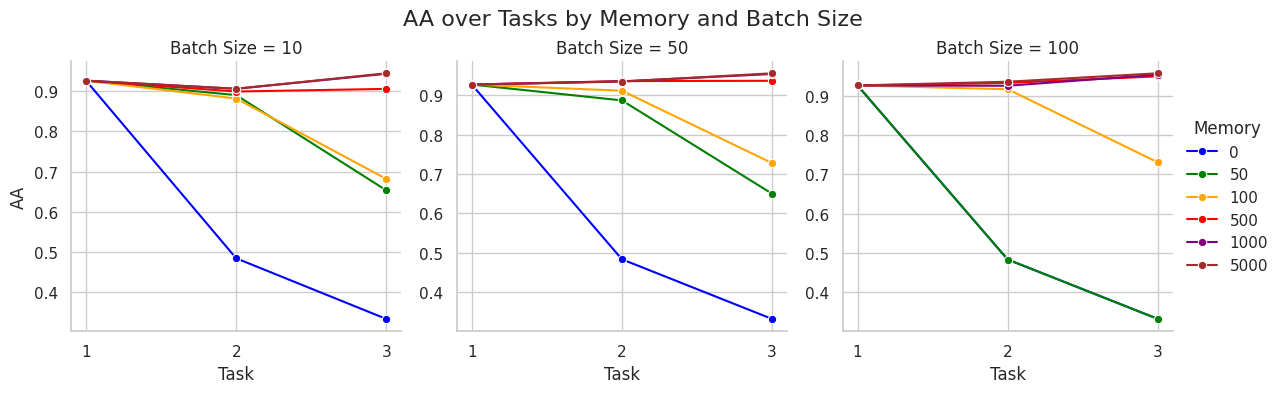

<Figure size 1200x500 with 0 Axes>

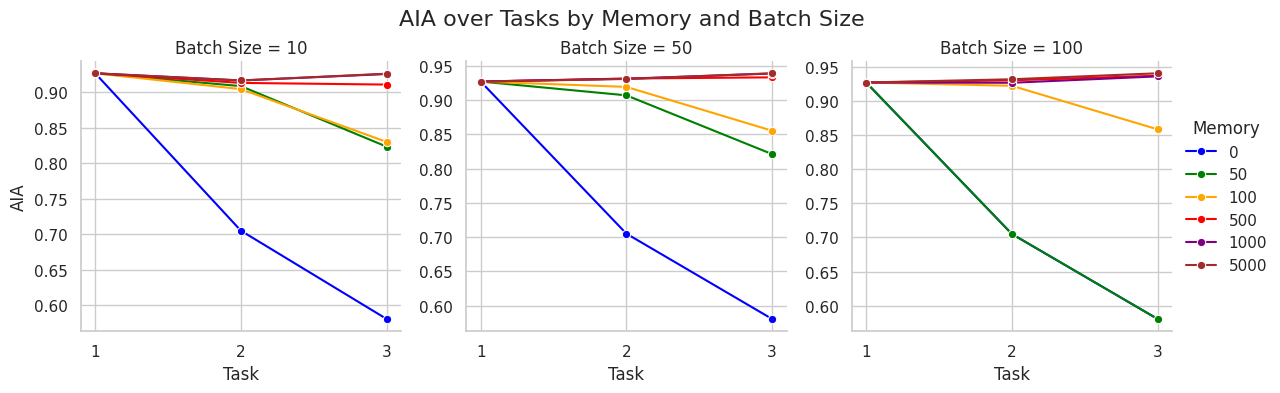

<Figure size 1200x500 with 0 Axes>

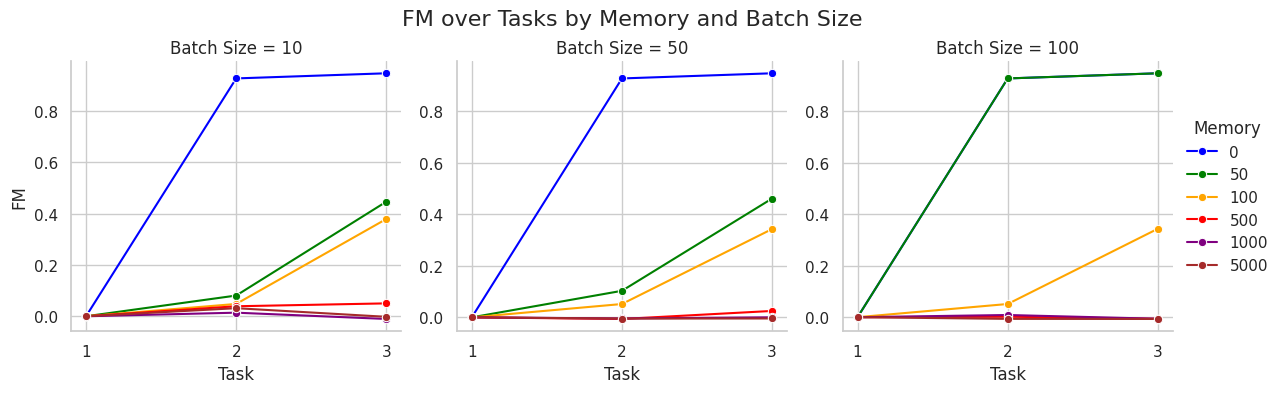

<Figure size 1200x500 with 0 Axes>

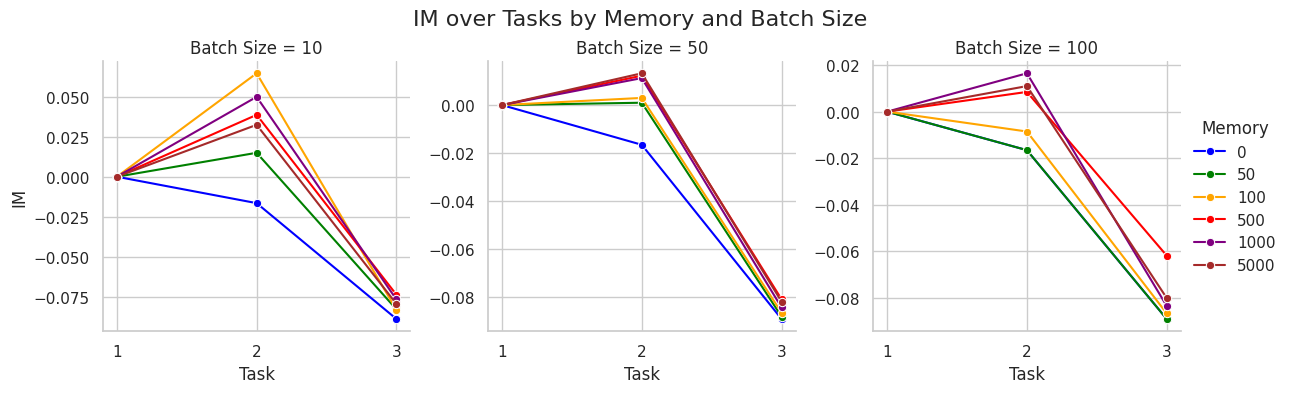

<Figure size 1200x500 with 0 Axes>

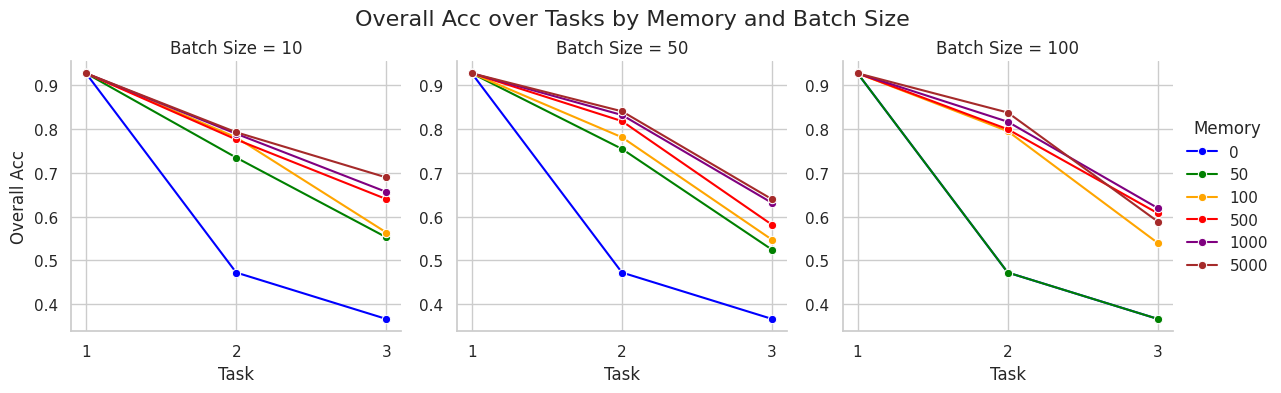

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette = {
    0: "blue",
    50: "green",
    100: "orange",
    500: "red",
    1000: "purple",
    5000: "brown"
}
sns.set(style="whitegrid")
indicators = ['AA', 'AIA', 'FM', 'IM', 'Overall Acc']

for metric in indicators:
    plt.figure(figsize=(12, 5))
    g = sns.FacetGrid(metrics_df, col="Batch", hue="Memory", col_wrap=3, height=4, sharey=False, palette=color_palette)
    g.map(sns.lineplot, "Task", metric, marker="o")
    g.add_legend(title="Memory")
    g.set_titles("Batch Size = {col_name}")
    g.set_axis_labels("Task", metric)
    g.set(xticks=range(1, num_tasks+1))
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{metric} over Tasks by Memory and Batch Size", fontsize=16)
    plt.show()


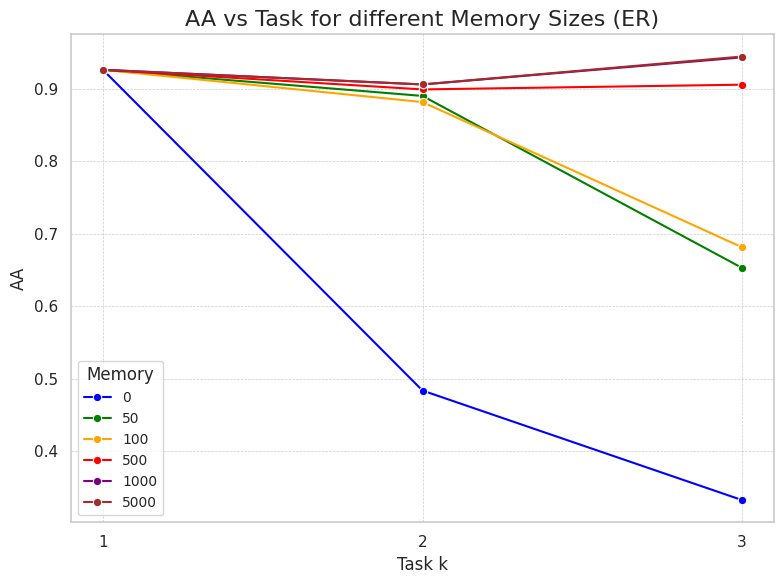

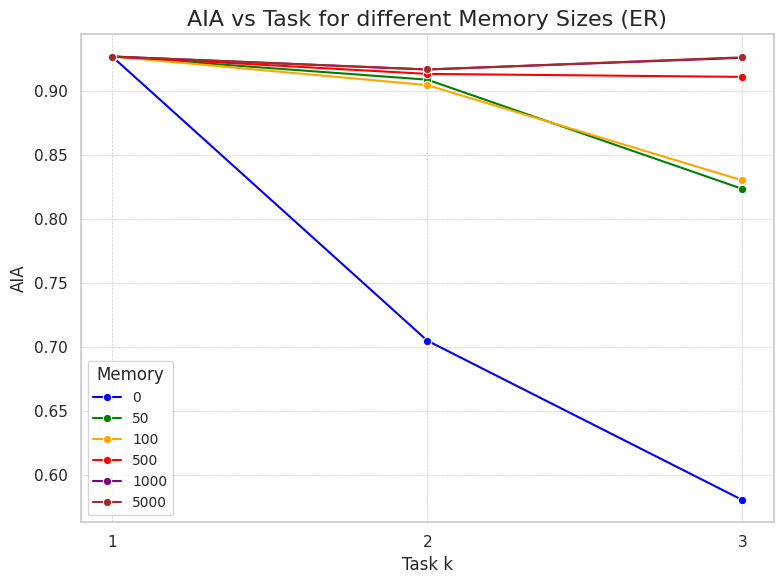

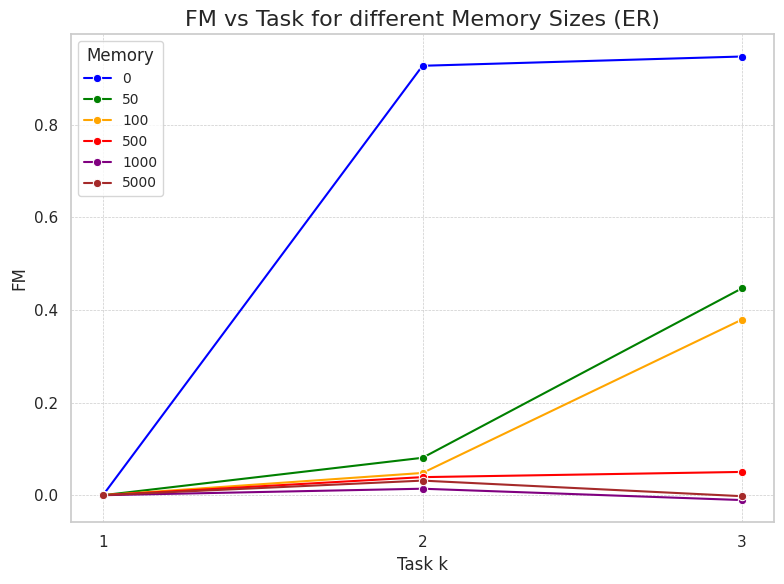

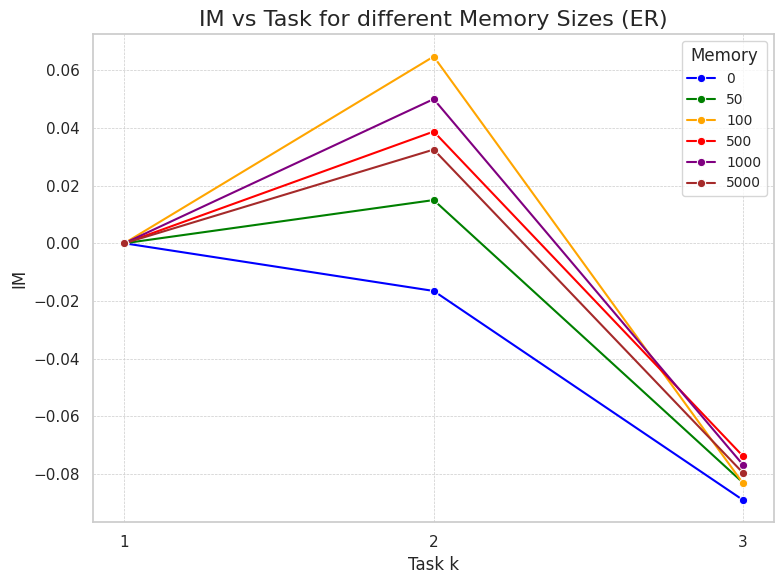

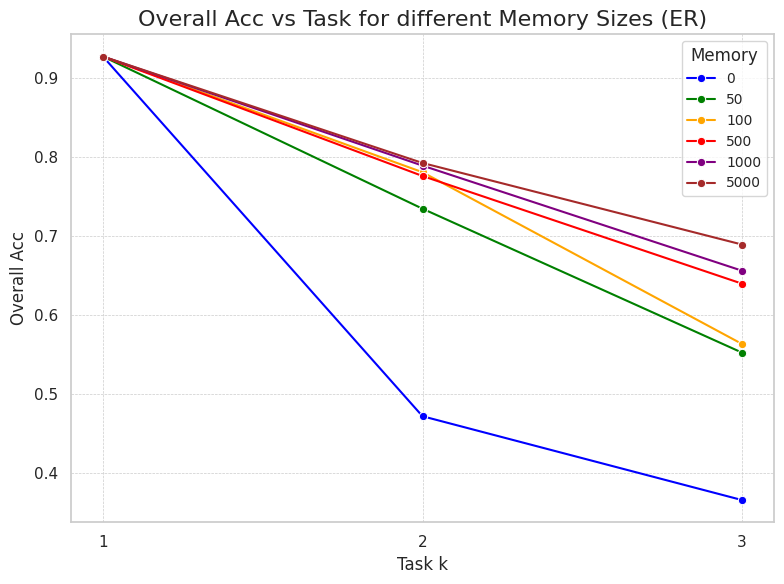

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# バッチサイズ = 10 に固定
metrics_df_bs10 = metrics_df[metrics_df["Batch"] == 10]

color_palette = {
    0: "blue",
    50: "green",
    100: "orange",
    500: "red",
    1000: "purple",
    5000: "brown"
}
sns.set(style="whitegrid")

indicators = ['AA', 'AIA', 'FM', 'IM', 'Overall Acc']

for metric in indicators:
    plt.figure(figsize=(8,6))
    sns.lineplot(
        data=metrics_df_bs10,  # ← batch size = 10 に絞った DataFrame
        x="Task",
        y=metric,
        hue="Memory",
        marker="o",
        palette=color_palette
    )
    plt.title(f"{metric} vs Task for different Memory Sizes (ER)", fontsize=16)
    plt.xlabel("Task k", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(range(1, num_tasks+1))
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(title="Memory", fontsize=10, title_fontsize=12)
    plt.tight_layout()
    plt.show()
